In [31]:
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

### Data loading

In [32]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth',map_location=torch.device('cpu'))['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)
inverse_model.load_state_dict(torch.load('./models/inverse_model_trained.pth',map_location=torch.device('cpu'))['model_state_dict'])
inverse_model.eval()
dataset=test_loader.dataset;
with torch.no_grad():
    mean, std = torch.tensor(dataset.scaler.mean_).to(DEVICE), torch.tensor(np.sqrt(dataset.scaler.var_)).to(DEVICE)
    x, y = dataset.x.to(DEVICE), dataset.y.to(DEVICE)
    x_dim = x.size()[1]

        # get MSE for the design
    y_pred = inverse_model(x, y)
print(y)

tensor([[ 1.5797,  1.3234,  0.3523, -1.0881],
        [ 0.4680,  1.4112,  0.6998,  0.7409],
        [-1.5128, -0.8051, -1.1828, -1.3008],
        ...,
        [ 0.0435, -0.5637, -0.0532, -1.1732],
        [-1.4724,  0.3799,  0.6709,  1.4640],
        [-0.0373,  1.5648,  1.0377,  0.1454]])


### Direct inverse training


Simple net Design RMSE loss 1.251
Simple net RMSE loss 80.897
Reconstruct RMSE loss 0.538
Reconstruct RMSE loss raw 0.067


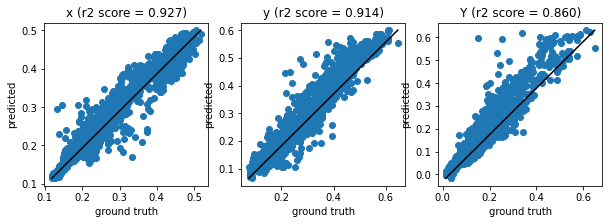

In [33]:
forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)
inverse_model.load_state_dict(torch.load('./models/inverse_model_trained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_simple_inverse(forward_model, inverse_model, test_loader.dataset)

plot_cie_raw_pred(cie_raw, cie_pred)
plt.show()


### Tandem (fixed decoder)

Tandem net Design RMSE loss 2.042
Tandem Design RMSE loss 138.686
Reconstruct RMSE loss 0.149
Reconstruct RMSE loss raw 0.019


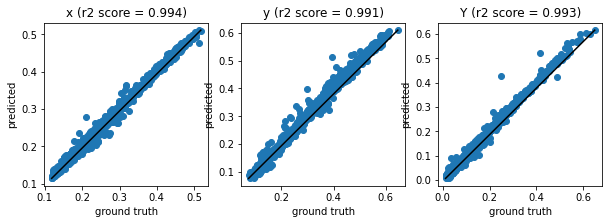

In [35]:
tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained.pth')['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_accuracy(tandem_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


### VAE

Simple net Design RMSE loss 1.573
Simple net RMSE loss 103.151
Reconstruct RMSE loss 0.737
Reconstruct RMSE loss raw 0.093


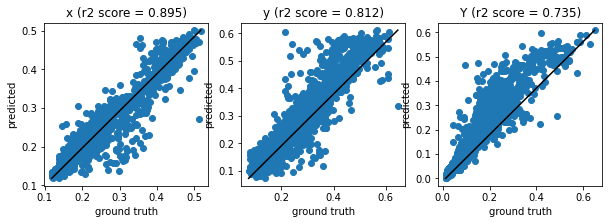

In [36]:
configs = get_configs('vae')
vae_model = cVAE(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_trained.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_inverse(forward_model, vae_model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)

### GAN


Simple net Design RMSE loss 2.785
Simple net RMSE loss 183.731
Reconstruct RMSE loss 1.592
Reconstruct RMSE loss raw 0.195


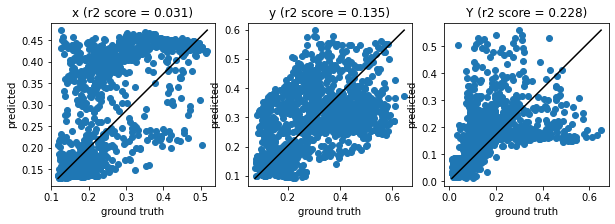

In [37]:
configs = get_configs('gan')
cgan = cGAN(3, 4, noise_dim = configs['noise_dim'], hidden_dim = 128).to(DEVICE)
cgan.load_state_dict(torch.load('./models/gan_trained.pth')['model_state_dict'])

cie_raw, param_raw, cie_pred, param_pred = evaluate_gan_inverse(forward_model, cgan, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)


### Inverse neural network

Simple net Design RMSE loss 1.883
Simple net RMSE loss 122.324
Reconstruct RMSE loss 0.579
Reconstruct RMSE loss raw 0.072


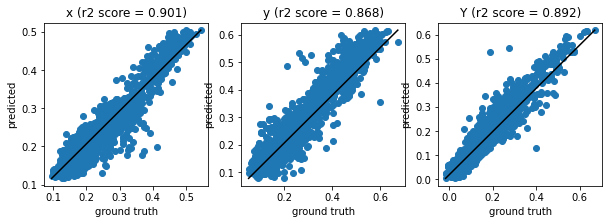

In [39]:
configs = get_configs('inn')
model = INN(configs['ndim_total'], configs['input_dim'], configs['output_dim'], dim_z = configs['latent_dim']).to(DEVICE)
model.load_state_dict(torch.load('./models/inn_trained.pth')['model_state_dict'], strict=False)

cie_raw, param_raw, cie_pred, param_pred = evaluate_inn_inverse(forward_model, model, configs, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)
